In [2]:
import torch
import torchvision.transforms as transforms
import os
import torch.nn.functional as F
# 학습 중 진행상황 print(진행률 막대)
import tqdm
import random
import cv2
from ipywidgets import interact
# 파일 및 디렉토리 작업
import shutil
import numpy as np
from PIL import Image
import re
# 다차원 이미지 처리
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
# 파일경로 다루기
from pathlib import Path
from torch import nn
# 텐서를 감싸기
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

# 1. 이미지 경로지정

In [3]:
# 원본 데이터셋 경로
dataset_dir = r'D:\Breast  Cancer Segmentation\Breast Cancer'

In [4]:
# 각 폴더에 대한 이미지 경로 dic생성(benign:양성 / malignant:악성 / normal:정상)
folder_list = os.listdir(dataset_dir)
folder_dic = {}
for i in folder_list:
    folder_dir = os.path.join(dataset_dir,i)
    img_list = os.listdir(folder_dir)
    img_list = [os.path.join(folder_dir,i) for i in img_list]
    folder_dic[i] = img_list

In [5]:
folder_list

['benign', 'malignant', 'normal']

In [6]:
folder_dic['benign']

['D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (1).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (1)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (10).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (10)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (100).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (100)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (100)_mask_1.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (101).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (101)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (102).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (102)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (103).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\

In [7]:
# 각각 폴더 리스트 생성
benign_list = folder_dic['benign']
malignant_list = folder_dic['malignant']
normal_list = folder_dic['normal']

In [8]:
# image, mask 결합확인
def show_mask(image, mask, cmap=None, alpha=0.4):
    image = cv2.imread(image)
    mask = cv2.imread(mask)
    plt.imshow(image)
    plt.imshow(mask, cmap=cmap, alpha=alpha)
    # plt.imshow(np.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

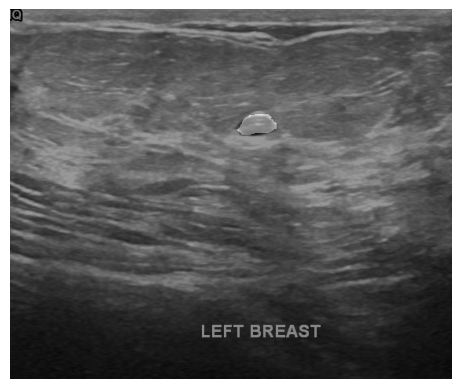

In [9]:
img = benign_list[0]
msk = benign_list[1]
show_mask(img, msk)

In [34]:
# 인터랙티브 함수 정의
index_name = input("Enter the folder name: ")
print(index_name)
index_list = folder_dic[index_name]
@interact(index=(0, len(index_list)-1))
def interact_image(index):
    img = cv2.imread(index_list[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_title = index_list[index].split('\\')[-1]
    plt.title(img_title)
    plt.imshow(img)

Enter the folder name:  benign


benign


interactive(children=(IntSlider(value=445, description='index', max=890), Output()), _dom_classes=('widget-int…

# 2. UNet 데이터셋 생성(img / mask)

In [11]:
# unet 데이터셋 폴더생성
img_msk_list = ['image','mask']
new_dataset_path = Path('./02. Unet_Dataset')
class_list = folder_list
unet_folder_list = []
for i in img_msk_list: 
    for j in class_list:
        unet_folder_list.append(new_dataset_path / i / j)
        (new_dataset_path / i / j).mkdir(parents=True, exist_ok=True)

In [12]:
# # unet 데이터셋 이미지 복사
# for i in class_list:
#     for j in folder_dic[i]:
#         # mask이미지 복사
#         if 'mask' in j:
#             destination = (new_dataset_path / 'mask' / i)
#             # _mask 삭제
#             destination_file = destination / Path(j).name.replace('_mask','').replace(' ', '').replace('(', '').replace(')', '')
#             img = cv2.imread(j, cv2.IMREAD_GRAYSCALE)
#             resized_img = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
#             cv2.imwrite(str(destination_file), resized_img)
#         # image복사
#         elif 'mask' not in j:
#             destination = (new_dataset_path / 'image' / i)
#             # 파일명 정리
#             destination_file = destination / Path(j).name.replace(' ', '').replace('(', '').replace(')', '')
#             img = cv2.imread(j)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             resized_img = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
#             cv2.imwrite(str(destination_file), resized_img)

In [13]:
# # unet 데이터셋 이미지 복사
# for i in class_list:
#     for j in folder_dic[i]:
#         # mask이미지 복사
#         if 'mask' in j:
#             destination = (new_dataset_path / 'mask' / i)
#             # _mask 삭제
#             destination_file = destination / Path(j).name.replace('_mask','').replace(' ', '').replace('(', '').replace(')', '')
#             shutil.copy2(j, destination_file)
#         # image복사
#         elif 'mask' not in j:
#             destination = (new_dataset_path / 'image' / i)
#             # 파일명 정리
#             destination_file = destination / Path(j).name.replace(' ', '').replace('(', '').replace(')', '')
#             shutil.copy2(j, destination)

In [14]:
# 마스크이미지 경로 추출
mask_dir = r'.\02. Unet_Dataset\mask'
mask_folders = os.listdir(mask_dir)
all_mask = []
for i in mask_folders:
    path = os.path.join(mask_dir, i)
    files = os.listdir(path)
    for j in files:
        whole_path = os.path.join(path, j)
        all_mask.append(whole_path)
len(all_mask)

780

In [15]:
# # 중복되는 마스크 통합
# for file in all_mask:
#     file_name = file.split('\\')[-1]
#     if '_' in file_name:
#         path1 = file.replace('_1','').replace('_2','')
#         path2 = file
#         img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
#         img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
#         dst = cv2.add(img1, img2)
#         cv2.imwrite(path1, dst)
#         os.remove(file)

In [16]:
# 마스크이미지 경로 추출
mask_dir = r'.\02. Unet_Dataset\mask'
mask_folders = os.listdir(mask_dir)
all_mask = []
for i in mask_folders:
    path = os.path.join(mask_dir, i)
    files = os.listdir(path)
    for j in files:
        whole_path = os.path.join(path, j)
        all_mask.append(whole_path)
len(all_mask)

780

In [17]:
# 마스크이미지 경로 추출
image_dir = r'.\02. Unet_Dataset\image'
image_folders = os.listdir(image_dir)
all_image = []
for i in image_folders:
    path = os.path.join(image_dir, i)
    files = os.listdir(path)
    for j in files:
        whole_path = os.path.join(path, j)
        all_image.append(whole_path)
len(all_image)

780

In [18]:
# bengin / malignant -> 색상변경
benign_dir = os.path.join(mask_dir, 'benign')
malignant_dir = os.path.join(mask_dir, 'malignant')
benign_files = [os.path.join(benign_dir,i) for i in os.listdir(benign_dir)]
malignant_files = [os.path.join(malignant_dir,i) for i in os.listdir(malignant_dir)]
print(len(benign_files),len(malignant_files))

437 210


In [19]:
# benign 양성(종양) - 파란색 표현
for i in benign_files:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    _,img_white = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bgr[img_white == 255] = [255, 0, 0]
    cv2.imwrite(i, img_bgr)

In [20]:
# malignant 악성(암) - 붉은색 표현
for i in malignant_files:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    _,img_white = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bgr[img_white == 255] = [0, 0, 255]
    cv2.imwrite(i, img_bgr)

In [35]:
# unet데이터셋 확인
all_image = sorted(all_image)
all_mask = sorted(all_mask)
@interact(index=(0, len(all_image)-1))
def interact_image(index):
    show_mask(all_image[index], all_mask[index], alpha=0.4)
    title = all_image[index].split('\\')[-1]
    plt.title(title)

interactive(children=(IntSlider(value=389, description='index', max=779), Output()), _dom_classes=('widget-int…

In [22]:
# 데이터셋 클래스 정의
class BreastDatasets(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform, mask_transform):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.img_files = []
        self.mask_files = []
        self.seed = np.random.randint(2024)

        for x in ['benign','malignant','normal']:
            file_img_dir = os.path.join(self.img_dir,x)
            file_mask_dir = os.path.join(self.mask_dir,x)
            for img_name in os.listdir(file_img_dir):
                if img_name.split('.')[-1] in ('png', 'jpg'):
                    self.img_files.append(os.path.join(file_img_dir, img_name))
                    self.mask_files.append(os.path.join(file_mask_dir, img_name))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, i):
        img = Image.open(self.img_files[i])
        if self.img_transform is not None:
            random.seed(self.seed)
            img = self.img_transform(img)

        mask = Image.open(self.mask_files[i]).convert('RGB')
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask

In [23]:
# # 데이터셋 클래스 정의
# class BreastDatasets(Dataset):
#     def __init__(self, img_dir, mask_dir, img_transform, mask_transform):
#         self.img_dir = img_dir
#         self.mask_dir = mask_dir
#         self.img_transform = img_transform
#         self.mask_transform = mask_transform
#         self.img_files = []
#         self.mask_files = []
#         self.seed = np.random.randint(2024)

#         for img_name in os.listdir(self.img_dir):
#             if img_name.split('.')[-1] in ('png', 'jpg'):
#                 self.img_files.append(os.path.join(self.img_dir, img_name))
#                 self.mask_files.append(os.path.join(self.mask_dir, img_name))

#     def __len__(self):
#         return len(self.img_files)

#     def __getitem__(self, i):
#         img = Image.open(self.img_files[i])
#         if self.img_transform is not None:
#             random.seed(self.seed)
#             img = self.img_transform(img)

#         mask = Image.open(self.mask_files[i]).convert('L') # 그레이스케일로 변환
#         if self.mask_transform is not None:
#             mask = self.mask_transform(mask)

#         return img, mask

# 3. Unet 구현

In [24]:
# UNET 클래스로 구현
class UNet(nn.Module):
    # 클래스의 갯수 상속
    def __init__(self, num_classes):
        # nn.Module(부모) 클래스의 기능을 상속
        super(UNet, self).__init__()
        self.num_classes = num_classes
        # 3채널을 받아서 64로 반환(1번째 레이어)
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64채널을 받아서 128채널로 반환(2번째 레이어)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 128채널을 받아서 256채널로 반환(3번째 레이어)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64채널을 받아서 128채널로 반환(4번째 레이어)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 512채널을 받아서 1024채널로 반환(5번째 레이어)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        # 디코딩(확장)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        # 3
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        # 4
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        # 결과물
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1)


    # n개의 채널을 받아서 n개의 채널로 내보내는 함수
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                             nn.ReLU(),
                             nn.BatchNorm2d(num_features=out_channels),
                             nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                             nn.ReLU(),
                             nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        # 컨볼루션 연산 -> 채널 상승
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256] : 배치 / 채널 / 이미지사이즈
        # 맥스풀링 -> 이미지 크기 감소
        contracting_12_out = self.contracting_12(contracting_11_out) #[-1, 64, 128, 128]
        # 2
        contracting_21_out = self.contracting_21(contracting_12_out) #[-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) #[-1, 128, 64, 64]
        # 3
        contracting_31_out = self.contracting_31(contracting_22_out) #[-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) #[-1, 256, 32, 32]
        # 4
        contracting_41_out = self.contracting_41(contracting_32_out) #[-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) #[-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1,512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024,32,32] -> [-1, 512,32,32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [25]:
# # UNET 클래스로 구현(원본)
# class UNet(nn.Module):
#     # 클래스의 갯수 상속
#     def __init__(self, num_classes):
#         # nn.Module(부모) 클래스의 기능을 상속
#         super(UNet, self).__init__()
#         self.num_classes = num_classes
#         # 3채널을 받아서 64로 반환(1번째 레이어)
#         self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
#         self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 64채널을 받아서 128채널로 반환(2번째 레이어)
#         self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
#         self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 128채널을 받아서 256채널로 반환(3번째 레이어)
#         self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
#         self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 64채널을 받아서 128채널로 반환(4번째 레이어)
#         self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
#         self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # 512채널을 받아서 1024채널로 반환(5번째 레이어)
#         self.middle = self.conv_block(in_channels=512, out_channels=1024)
#         self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
#         # 디코딩(확장)
#         self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
#         # 3
#         self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
#         # 4
#         self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
#         # 결과물
#         self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=2)


#     # n개의 채널을 받아서 n개의 채널로 내보내는 함수
#     def conv_block(self, in_channels, out_channels):
#         block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
#                              nn.ReLU(),
#                              nn.BatchNorm2d(num_features=out_channels),
#                              nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
#                              nn.ReLU(),
#                              nn.BatchNorm2d(num_features=out_channels))
#         return block

#     def forward(self, X):
#         # 컨볼루션 연산 -> 채널 상승
#         contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256] : 배치 / 채널 / 이미지사이즈
#         # 맥스풀링 -> 이미지 크기 감소
#         contracting_12_out = self.contracting_12(contracting_11_out) #[-1, 64, 128, 128]
#         # 2
#         contracting_21_out = self.contracting_21(contracting_12_out) #[-1, 128, 128, 128]
#         contracting_22_out = self.contracting_22(contracting_21_out) #[-1, 128, 64, 64]
#         # 3
#         contracting_31_out = self.contracting_31(contracting_22_out) #[-1, 256, 64, 64]
#         contracting_32_out = self.contracting_32(contracting_31_out) #[-1, 256, 32, 32]
#         # 4
#         contracting_41_out = self.contracting_41(contracting_32_out) #[-1, 512, 32, 32]
#         contracting_42_out = self.contracting_42(contracting_41_out) #[-1, 512, 16, 16]
#         middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]

#     def forward(self, X):
#         contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
#         contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
#         contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
#         contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
#         contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
#         contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
#         contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
#         contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
#         middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
#         expansive_11_out = self.expansive_11(middle_out) # [-1,512, 32, 32]
#         expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024,32,32] -> [-1, 512,32,32]
#         expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
#         expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
#         expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
#         expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
#         expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
#         expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
#         output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
#         return output_out

# 4. Dice Score와 IoU 메트릭 함수 정의하기

In [26]:
# Dice coefficient: 두 개의 집합 간의 유사성을 측정하는 데 사용되는 통계적인 지표
# # 2×∣A∩B∣ / ∣A∣+∣B∣ (교집합*2) / (a크기+b크기)
# 0에서 1까지의 값을 가지며, 1에 가까울수록 두 집합이 유사
# 1e-6: 0.000001
# assert 조건, "에러 메세지"
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # 입력텐서과 결과텐서가 동일한지 체크
    assert input.size() == target.size()
    # 입력이 3차원 이면 True(dim:차원 수 반환)
    assert input.dim() == 3 or not reduce_batch_first
    # 차원: (-1,-2)_마지막 두개 텐서(2차원)
    sum_dim = (-1,-2) if input.dim() == 2 or not reduce_batch_first else (-1,-2,-3)
    # 교집합: 2차원이면 2개에 대한 곱 / 3차원이면 마지막 세 개 차원에 대한 곱
    inter = 2*(input * target).sum(dim=sum_dim)
    # 합집합
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    # torch.where() : 조건에 다른 연산함수 / 조건을 만족하면 0번째 아니면 1번째 반환
    sets_sum = torch.where(sets_sum==0, inter, sets_sum)
    # 완벽한 0의 분모나 분자가 나오면 에러가 나서 epsilon(실수) 더 해줌
    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

# IoU(Intersection over Union):객체 검출 및 객체 분할과 같은 컴퓨터 비전 작업에서 사용되는 평가지표
# 두 개의 영역 또는 객체가 주어졌을 때, IoU는 교집합을 합집합으로 나눈 것을 나타냄. 0에서 1사이의 값을 갖음
def iou(y_true, y_pred, epsilon: float = 1e-6):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection+epsilon) / (union+epsilon)

In [27]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def find_latest_model_path(dir):
    model_paths = []
    epochs = []
    for path in Path(dir).glob('*.pth'):
        if 'epoch' not in path.stem:
            continue
        model_paths.append(path)
        parts = path.stem.split('_')
        epoch = int(parts[-1])
        epochs.append(epoch)

    if len(epochs) > 0:
        epochs = np.array(epochs)
        max_idx = np.argmax(epochs)
        return model_paths[max_idx]
    else:
        return None

# param_groups: 옵티마이저 객체 속성. 요소는 딕셔너리이며 매개변수 그룹에 대한 정보를 저장
def adjust_learning_rate(optimizer, epoch, lr):
    lr = lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# 5. train학습함수

In [28]:
def train(train_loader, model, criterion, optimizer, valid_loader, model_dir, n_epoch, batch_size, lr, device):
    latest_model_path = find_latest_model_path(model_dir)
    best_model_path = os.path.join(*[model_dir, 'model_best.pth'])

    if latest_model_path is not None:
        state = torch.load(latest_model_path)
        epoch = state['epoch']
        model.load_state_dict(state['model'])
        assert Path(best_model_path).exists() == True, f'best model path {best_model_path} does not exist!'
        best_state = torch.load(latest_model_path)
        min_val_los = best_state['valid_loss']

        print(f'Restored model: {epoch}, Min validation loss: {min_val_los}')
        epoch += 1
        print(f'{epoch}')
    else:
        print('epoch: 0')
        epoch = 0
        min_val_los = 9999

    valid_losses = []

    for epoch in range(epoch, n_epoch):
        adjust_learning_rate(optimizer, epoch, lr)
        tq = tqdm.tqdm(total=(len(train_loader) * batch_size))
        tq.set_description(f'Epoch {epoch}')

        losses = AverageMeter()
        t_iou = 0
        t_dice = 0

        model.train()
        for i, (input, target) in enumerate(train_loader):
            # Variable: 텐서를 대체하기 위해 사용되던 클래스(과거 버전의 텐서)
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)

            masks_pred = model(input_var)
            pred = F.sigmoid(masks_pred)
            target_mask = target_var

            pred[pred>0.5] = 1
            pred[pred<=0.5] = 0
            target_mask[target_mask>0.5] = 1
            target_mask[target_mask<=0.5] = 0

            t_dice += dice_coeff(pred, target_mask)
            t_iou += iou(pred, target_mask)

            masks_probs_flat = masks_pred.view(-1)
            true_masks_flat = target_var.view(-1)

            loss = criterion(masks_probs_flat, true_masks_flat)
            losses.update(loss)
            tq.set_postfix(loss='{:.5f}'.format(losses.avg))
            tq.update(batch_size)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'train miou : {t_iou/len(train_loader):.5f} train dice score : {t_dice/len(train_loader):.5f}')
        valid_metrics = valid(model, valid_loader, criterion)
        valid_loss = valid_metrics['valid_loss']
        valid_dice = valid_metrics['v_dice']
        valid_iou = valid_metrics['v_iou']
        valid_losses.append(valid_loss)
        print(f'valid_loss = {valid_loss:.5f}')
        print(f'valid miou : {valid_iou/len(valid_loader):.5f} valid dice score : {valid_dice/len(valid_loader):.5f}')
        tq.close()

        epoch_model_path = os.path.join(*[model_dir, f'model_epoch_{epoch}.pth'])
        torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'valid_loss': valid_loss,
            'train_loss': losses.avg
        }, epoch_model_path)

        if valid_loss < min_val_los:
            min_val_los = valid_loss

            torch.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'valid_loss': valid_loss,
                'train_loss': losses.avg
            }, best_model_path)

In [29]:
def valid(model, val_loader, criterion):
    losses = AverageMeter()
    v_iou = 0
    v_dice = 0
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)
            output = model(input_var)
            loss = criterion(output, target_var)
            losses.update(loss.item(), input_var.size(0))
            pred = F.sigmoid(output)
            target_mask = target_var

            pred[pred>0.5] = 1
            pred[pred<=0.5] = 0
            target_mask[target_mask>0.5] = 1
            target_mask[target_mask<=0.5] = 0

            v_dice += dice_coeff(pred, target_mask)
            v_iou += iou(pred, target_mask)

    return {'valid_loss': losses.avg, 'v_dice': v_dice, 'v_iou': v_iou}

# 6. 파라미터 정의

In [30]:
# 모델 저장 폴더
model_dir = './model_weights'
os.makedirs(model_dir, exist_ok=True)

# 데이터 저장 폴더
data_dir = './02. Unet_Dataset'
DIR_IMG = os.path.join(data_dir, 'image')
DIR_MASK = os.path.join(data_dir, 'mask')

# Device 할당
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.001
momentum = 0.9
weight_decay = 1e-4
batch_size = 8
num_workers = 8
n_epoch = 10

In [31]:
device

device(type='cpu')

In [32]:
# 모델 할당
model = UNet(num_classes=1)

# 옵티마이저 정의
# weight_decay: L2정규화, 모델이 과적합되지 않도록 패널티 값
optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum, weight_decay=weight_decay)

# 손실함수 정의
criterion = nn.BCEWithLogitsLoss().to(device)

# transforms
channel_mean = [0.485, 0.456, 0.406]
channel_stds = [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
val_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
mask_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256)])

# 데이터셋
dataset = BreastDatasets(img_dir=DIR_IMG, img_transform=train_tfms, mask_dir=DIR_MASK,
                        mask_transform=mask_tfms)
train_size = int(0.85*len(dataset))
valid_size = len(dataset) - train_size

In [33]:
dataset[0]

(tensor([[[-1.3130, -1.9980, -1.7925,  ...,  1.5468,  1.4098,  0.9988],
          [-0.2171, -2.1179,  1.8037,  ...,  1.2728,  1.3755,  1.2385],
          [-0.1143, -0.0801,  0.6049,  ...,  1.1529,  0.8447,  0.6563],
          ...,
          [-1.6555, -1.6898, -1.6727,  ..., -1.7412, -1.7583, -1.7925],
          [-1.6727, -1.7240, -1.7069,  ..., -1.7925, -1.7925, -1.6727],
          [-1.7069, -1.7069, -1.6898,  ..., -1.5699, -1.5528, -1.5528]],
 
         [[-1.2129, -1.9132, -1.7031,  ...,  1.7108,  1.5707,  1.1506],
          [-0.0924, -2.0357,  1.9734,  ...,  1.4307,  1.5357,  1.3957],
          [ 0.0126,  0.0476,  0.7479,  ...,  1.3081,  0.9930,  0.8004],
          ...,
          [-1.5630, -1.5980, -1.5805,  ..., -1.6506, -1.6681, -1.7031],
          [-1.5805, -1.6331, -1.6155,  ..., -1.7031, -1.7031, -1.5805],
          [-1.6155, -1.6155, -1.5980,  ..., -1.4755, -1.4580, -1.4580]],
 
         [[-0.9853, -1.6824, -1.4733,  ...,  1.9254,  1.7860,  1.3677],
          [ 0.1302, -1.8044,

In [32]:
# 모델 할당
model = UNet(num_classes=3)

# 옵티마이저 정의
# weight_decay: L2정규화, 모델이 과적합되지 않도록 패널티 값
optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum, weight_decay=weight_decay)

# 손실함수 정의
criterion = nn.BCEWithLogitsLoss().to(device)

# transforms
channel_mean = [0.485, 0.456, 0.406]
channel_stds = [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
val_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256),
                                 transforms.Normalize(channel_mean, channel_stds)])
mask_tfms = transforms.Compose([transforms.ToTensor(), transforms.Resize(256)])

# 데이터셋
dataset = BreastDatasets(img_dir=DIR_IMG, img_transform=train_tfms, mask_dir=DIR_MASK,
                        mask_transform=mask_tfms)
train_size = int(0.85*len(dataset))
valid_size = len(dataset) - train_size

# train/ val 데이터셋 분할
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 데이터로더
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=num_workers)

model.to(device)

# train(train_loader, model, criterion, optimizer, valid_loader, model_dir, n_epoch, batch_size, lr, device)

UNet(
  (contracting_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contr

In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')